# XGBoost Model

# Data importing and splitting 

In [1]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import normalized_mutual_info_score,roc_auc_score,recall_score,f1_score,confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import preprocessing
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer,fbeta_score
f2_score=make_scorer(fbeta_score,beta=2)

In [43]:
data_jan=pd.read_csv('/data/xx715/Jan_data.csv',index_col=0)
data_feb=pd.read_csv('/data/xx715/Feb_data.csv',index_col=0)

In [44]:
X_train1=data_jan.drop('is_churn',1)
x_cols = [x for x in X_train1.columns if x != 'std_sec']
y_train=data_jan['is_churn']
scaler=preprocessing.StandardScaler()
X_train=X_train1
X_train[x_cols]=scaler.fit_transform(X_train1[x_cols])
X_train=pd.DataFrame(X_train,columns=X_train1.columns,index=X_train1.index)

X_val1, X_test1, y_val, y_test = train_test_split(data_feb.drop('is_churn',1),data_feb.is_churn,test_size=0.5)
X_val=X_val1
X_val[x_cols]=scaler.fit_transform(X_val1[x_cols])
X_test=scaler.fit_transform(X_test1)
X_val=pd.DataFrame(X_val,columns=X_val1.columns,index=X_val1.index)
X_test=pd.DataFrame(X_test,columns=X_test1.columns,index=X_test1.index)

In [7]:
from sklearn.model_selection import PredefinedSplit
X=X_train.append(X_val,ignore_index=True)
y=pd.concat([y_train,y_val])
split_index=np.zeros(len(X),dtype=int)
split_index[:len(X_train)]=-1
split_index=split_index.tolist()
pds = PredefinedSplit(test_fold = split_index)

In [13]:
linspace = [2**(i) for i in range(10,20)]+[len(X_train)]
xgb_mean = np.zeros(len(linspace))
xgb_se = np.zeros(len(linspace))

#Run 20 resampling
for i,size in enumerate(linspace):
    xgb_mean[i],xgb_se[i]= logloss_resampling(X_train,y_train,20, size)
    print('For sample size {}, The mean logloss is {}.'.format(size,xgb_mean[i]))

For sample size 1024, The mean logloss is 0.4461647716221355.
For sample size 2048, The mean logloss is 0.41884252462249777.
For sample size 4096, The mean logloss is 0.3825022692370307.
For sample size 8192, The mean logloss is 0.3307450371837777.
For sample size 16384, The mean logloss is 0.29262194600468716.
For sample size 32768, The mean logloss is 0.2678434816742731.
For sample size 65536, The mean logloss is 0.25124541246069626.
For sample size 131072, The mean logloss is 0.23953985232688374.
For sample size 262144, The mean logloss is 0.23195320906869865.
For sample size 524288, The mean logloss is 0.22686886637528453.
For sample size 272830, The mean logloss is 0.23170643243101025.


# Leaning Curve &Resampling

In [7]:
def logloss_resampling(train,train_y,nruns, sampsize):
    
    loglosses = []
    
    #XGBoost
    my_model =  xgboost.XGBClassifier(n_jobs=-1,tree_method='hist')
    #fit the models and compute logloss on test data
    for i in range(nruns):
        index_list = np.random.randint(0, len(train), size=sampsize)
        train_samp = train.iloc[index_list]
        y_sample = train_y.iloc[index_list]
        my_model.fit(train_samp,y_sample)
        loglosses.append(log_loss(train_y, my_model.predict_proba(train)[:, 1]))
       
    #Returns the mean(logloss) and SE(logloss)
    return np.mean(loglosses),np.std(loglosses,ddof = 1)/np.sqrt(nruns)

# Tuning paramters with grid search

In [53]:
def gd_search(X,y):
    xgb_clf = xgboost.XGBClassifier(booster='dart',tree_method='hist',n_jobs=-1,objective='binary:logistic')
    param=dict(n_estimators=[600,700,800],
               max_depth=[6,7,8,10],min_child_weight=[3,4,5],
               subsample=[0.7,0.8],learning_rate=[0.001,0.002,0.003],
               scale_pos_weight=[9])
    
    gd_clf = GridSearchCV(estimator=xgb_clf, cv=pds, param_grid=param, 
                                n_jobs=-1,scoring=f2_score, verbose=10)
    gd_clf.fit(X,y)
    best_param=gd_clf.best_params_
    cv_results=pd.DataFrame(gd_clf.cv_results_)
    return gd_clf,best_param,cv_results

In [ ]:
clf,param,cv_results=gd_search(X,y)

Fitting 1 folds for each of 216 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


In [28]:
param

{'learning_rate': 0.001,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 800,
 'scale_pos_weight': 9,
 'subsample': 0.7}

In [26]:
auc=roc_auc_score(y_val,clf.predict_proba(X_val)[:,1])
f1=f1_score(y_val,clf.predict(X_val))
f2=fbeta_score(y_val,clf.predict(X_val), beta=2)
print('The Validation Fbeta score is {}'.format('%.5f'%f2))

The Validation Fbeta score is 0.45466


# Best model on testing data

In [27]:
auc=roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
f1=f1_score(y_test,clf.predict(X_test))
f2=fbeta_score(y_test,clf.predict(X_test), beta=2)
print('The testAUC score is {}'.format('%.5f'%auc))
print('The test f2 score is {}'.format('%.5f'%f2))

The test AUC score is 0.75597
The test Fbeta score is 0.43949


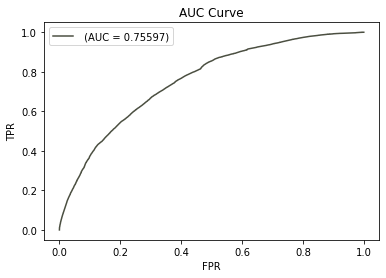

In [36]:
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
#roc_auc = auc(fpr,tpr)
c = (np.random.rand(), np.random.rand(), np.random.rand())
plt.plot(fpr, tpr, color = c, label =  ' (AUC = %0.5f)' % auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC Curve')
plt.legend()

Text(0.5, 1.0, 'Mean Logloss and Confidence Interval')

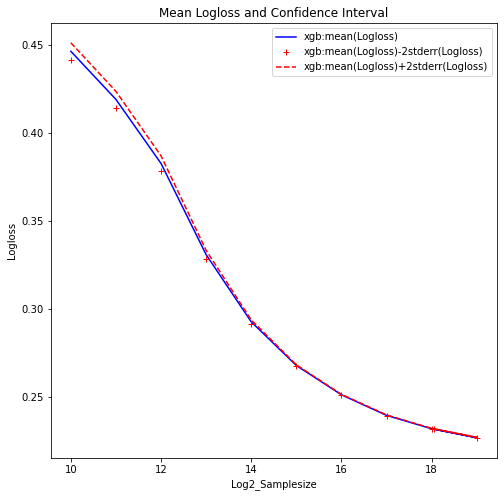

In [14]:
plt.figure(figsize = (8,8))
plt.plot(np.log2(linspace),xgb_mean,'b',label = 'xgb:mean(Logloss)')
plt.plot(np.log2(linspace),xgb_mean-2*xgb_se,'r+',label = 'xgb:mean(Logloss)-2stderr(Logloss)')
plt.plot(np.log2(linspace),xgb_mean+2*xgb_se,'r--',label = 'xgb:mean(Logloss)+2stderr(Logloss)')

plt.legend()
plt.xlabel('Log2_Samplesize')
plt.ylabel('Logloss')
plt.title('Mean Logloss and Confidence Interval')